# Predicción de mortalidad en pacientes de ICU

El presente notebook refiere al desarrollo del proyecto mencionado en:

Se realizarán dos stacks de modelos (cada stack es igual, cambia el tratamiento de datos). El primero consta con lecturas de las primeras 48 horas de los pacientes, sin tratamiento adicional. El segundo recibe el mismo pre-procesamiento, sin embargo, para balancear las clases se utilizará una técnica de Oversampling.


## 1.- Lectura y preprocesamiento de datos

In [2]:
import csv
import numpy as np
import pandas as pd
from collections import defaultdict
import os
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler 
from sklearn.impute import SimpleImputer 
from sklearn.metrics import roc_curve, auc
from scipy import interp
import matplotlib.pyplot as plt
import warnings



import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier
import warnings


warnings.filterwarnings('ignore')


#Leemos el primer conjunto de datos para prueba y entrenamiento,
#en este archivo "outcomes" se presentan las variables de "alta" de paciente.
outcomes=pd.read_csv('DATA/data/Outcomes-a_b.csv')


def dict_outcomes(ruta):
    """
    Se crea un archivo para leer cada una de las entradas de outcomes
    
    Regresa outcomes, un diccionario con clave id paciente, con items lista con id-saps-sofa-surv-stay-death
    """
    with open(ruta) as file:
        inpu=csv.reader(file)
        next(inpu)
        outcomes=defaultdict(list)
        for i in inpu:
            outcomes[i[0]]=i
        return outcomes
outcomes={}
outcomes=dict_outcomes('./DATA/data/Outcomes-a_b.csv')
outcomes_test=dict_outcomes('./DATA/data/Outcomes-c.csv')

filepath_patients='DATA/data/set-a_b'
def read_pat(filepath_patients,icustay):
    """
    Crea una clave para cada nueva variable, por paciente
    
    Regresa un diccionario donde las claves son los id de paciente, y el item son diccionarios, donde la clave
    es la variable leída (i,e: Weight, heart rate, etc.) con tuplas de ("Hora leída", "valor leído")
    """
    data_icu = {}
    for icustay_id in icustay.keys():
        file = '{}.txt'.format(icustay_id)
        f = open(os.path.join(filepath_patients,file))
        read_data = csv.reader(f)
        next(read_data) 
        next(read_data) 
        data = defaultdict(list)
        for row in read_data:
            data[row[1]].append((row[0],row[2]))
            data_icu[icustay_id] = data
    return data_icu

data_icu= read_pat('DATA/data/set-a_b/', outcomes)
data_icu_test=read_pat('DATA/data/set-c/', outcomes_test)

outcomes_df=pd.read_csv('./DATA/data/Outcomes-a_b.csv', index_col=None)
outcomes_df_test=pd.read_csv('./DATA/data/Outcomes-c.csv', index_col=None)

outcomes_df.index=outcomes_df['RecordID']
outcomes_df_test.index=outcomes_df_test['RecordID']


"""
Estas son las variables que utilizaremos para iterar nuestro modelo.
"""
vars_estaticas = ['Age', 'Gender', 'Height', 'ICUType']
vars_dinamicas = ['Albumin','ALP','ALT','AST','Bilirubin','BUN','Cholesterol',
                'Creatinine','DiasABP','FiO2','GCS','Glucose','HCO3',
                'HCT','HR','K','Lactate','Mg','MAP','MechVent',
                'Na','NIDiasABP','NIMAP','NISysABP','PaCO2',
                'PaO2','pH','Platelets','RespRate','SaO2',
                'SysABP','Temp','TroponinI','TroponinT','WBC','Weight'] 
vars_outcomes=['RecordID', 'SAPS-I', 'SOFA', 'Length_of_stay', 'Survival',
       'In-hospital_death']
    
def analysis_data(data):
    """ Extraemos cada una de las variables listadas arriba
        Regresa una lista de features que vamos a usar
    """
    features = {} 
    values_features = {}
    for name in vars_estaticas:
        valor = float(data[name][0][1])
        if valor < 0: #Los nulos estaban llenos con -1 (si fueron registrados), los reemplazamos
            features[name] = np.nan
        else:
            features[name] = float(data[name][0][1])
    for name in vars_dinamicas:
                
        if name in data:
            values=[]
            for d in data[name]:
                if int(d[0].split(':')[0])>48:
                    break
                values.append(float(d[1]))
            if valor < 0: 
                features[name] = np.nan
            else:
                values_features[name] = values
        features.update(values_features)
        
   
    return features

obtain_features = [] 
labels = []
ids = []
count_missing_weight = 0
for id, data in data_icu.items(): 
    features = analysis_data(data) #metemos en features un diccionario para cada paciente que posee todas sus variables
    features.update({'SAPS':float(outcomes[id][1]),
                           'SOFA': float(outcomes[id][2]),
                           'STAY': float(outcomes[id][3]),
                           'SURV': float(outcomes[id][4])})
    obtain_features.append(features)
    labels.append(outcomes[id][5]) # recuperamos la etiqueta "In-hospital_death"
    ids.append(id)
      

obtain_features = pd.DataFrame(obtain_features)
labels = pd.DataFrame(labels, columns = ['hospital_death'])
pd_data = pd.concat([obtain_features, labels], axis = 1, sort = False) #Unimos todos los features, incluido el target



"""
Ahora realizaremos lo mismo para test
"""

obtain_features_t = [] 
labels_t = []
ids_t = []
count_missing_weight_t = 0
for id, data in data_icu_test.items(): 
    features_t = analysis_data(data) 
    features_t.update({'SAPS':float(outcomes_test[id][1]),
                           'SOFA': float(outcomes_test[id][2]),
                           'STAY': float(outcomes_test[id][3]),
                           'SURV': float(outcomes_test[id][4])})
    obtain_features_t.append(features)
    labels_t.append(outcomes_test[id][5])
    ids_t.append(id)
      
obtain_features_t = pd.DataFrame(obtain_features_t)
labels_t = pd.DataFrame(labels_t, columns = ['hospital_death'])
pd_data_test = pd.concat([obtain_features_t, labels_t], axis = 1, sort = False) 

"""
Ahora, si la variable tiene más del 25% de nulos, la eliminamos, y tenemos una lista de las variables que usarmos
"""
pd_data.isnull().sum()
pd_data2=pd_data.drop(pd_data.columns[pd_data.isnull().mean()>0.25], axis=1)

vars_estaticas_less = ['Age', 'ICUType', 'Gender','SOFA','STAY','SURV','SAPS']
vars_dinamicas_less = ['Weight', 'BUN', 'Creatinine', 'HCT','HR', 'GCS', 'Temp', 'Platelets', 'HCO', 
                       'Na', 'WBC', 'K', 'Mg', 'Glucose', 'NISysABP', 'NIDiasABP', 'NIMAP', 'pH', 
                       'PaCO', 'PaO', 'DiasABP', 'SysABP', 'MAP', 'FiO', 'MechVent', 'Lactate', 'Height']



def set_features_to_nan(name):
  """
  Si el valor de una variable no fue registrado, le asignaremos NAN
  """
  values_features = {}
  values_features['{}_min'.format(name)] = np.nan
  values_features['{}_max'.format(name)] = np.nan
  values_features['{}_mean'.format(name)] = np.nan
  values_features['{}_first'.format(name)] = np.nan
  values_features['{}_last'.format(name)] = np.nan
  values_features['{}_diff'.format(name)] = np.nan
  values_features['{}_var'.format(name)] = np.nan
  return values_features
def features_series(data):
    """
    Esta funcion construye los valores que queremos tener, esto es la media, varianza, etc. Y la agregamos al
    diccionario, es la última parte del tratamiento.
    """
    pre_features = {}
    pre_values_features = {}
    age_value = []
    missing_weight = False
    for name in vars_estaticas_less:
        valor = float(data[name][0][1])
        if valor < 0:
            pre_features[name] = np.nan
        elif name == "Age" and valor > 90:
            pre_features[name] = 91.4 #Si la persona es muy longeva debemos reemplazar la edad, es una regla
        
        else:
            pre_features[name] = float(data[name][0][1])
    for parameter in vars_dinamicas_less:
        if parameter in data:
            values = [float(d[1]) for d in data[parameter]]
            if not values: 
                missing_weight = True
                pre_values_features = set_features_to_nan(parameter)
            else: 
                pre_values_features['{}_min'.format(parameter)] = min(values)
                pre_values_features['{}_max'.format(parameter)] = max(values)
                pre_values_features['{}_mean'.format(parameter)] = np.mean(values)
                pre_values_features['{}_var'.format(parameter)] = np.var(values)
                pre_values_features['{}_first'.format(parameter)] = values[0]
                pre_values_features['{}_last'.format(parameter)] = values [-1]
                pre_values_features['{}_diff'.format(parameter)] = values[-1] - values[0]
        pre_features.update(pre_values_features)
    return pre_features


def preprocessing(data_icu):
    """
    Hacemos la union de los datos anteriores
    """
    pre_features = []
    count_missing_weight = 0
    for id, data in data_icu.items():
        feats = features_series(data)
        pre_features.append(feats)
    return pre_features

"""
Agregamos las claves para las medidas de outcomes y las inicializamos como estáticas
"""
for i in data_icu.keys():
    data_icu[i].update({'SAPS':[('00:00',float(outcomes[i][1]))],
                           'SOFA':[('00:00', float(outcomes[i][2]))],
                           'STAY':[('00:00', float(outcomes[i][3]))],
                           'SURV':[('00:00', float(outcomes[i][4]))]})
    
for i in data_icu_test.keys():
    data_icu_test[i].update({'SAPS':[('00:00',float(outcomes_test[i][1]))],
                           'SOFA':[('00:00', float(outcomes_test[i][2]))],
                           'STAY':[('00:00', float(outcomes_test[i][3]))],
                           'SURV':[('00:00', float(outcomes_test[i][4]))]})
    
pre_features_test = preprocessing(data_icu_test)
pre_features_test = pd.DataFrame(pre_features_test)
pre_features = preprocessing(data_icu)
pre_features = pd.DataFrame(pre_features)



###########################################################
"""
Eliminamos ciertas varaibles altamente descriptivas del target, poseen una correlacion de aprox .49,
sin embargo, las variables representan algo que contradice la técnica, ya que mis valores son de las primeras 48 horas,
estas variables sólo pueden ser conocidas al final de la estancia del paciente (por esto la alta correlacion)
"""

all_data = pd.concat([pre_features, labels], axis = 1, sort = False)
x_all = all_data.drop(['hospital_death', 'SURV', 'STAY'], axis = 1) #features
y_all = all_data.hospital_death #label
feature_list = x_all.columns
print(len(feature_list), feature_list) 

all_data_test = pd.concat([pre_features_test, labels_t], axis = 1, sort = False)
x_all_t = all_data_test.drop(['hospital_death', 'SURV', 'STAY'], axis = 1) #features
y_all_t = all_data_test.hospital_death #label
feature_list_t = x_all_t.columns
print(len(feature_list_t)) 

####
all_data['hospital_death']=list(map(int, list(all_data['hospital_death'])))


all_data.drop(['SURV','STAY'], axis=1, inplace=True)

all_data_test.drop(['SURV','STAY'], axis=1, inplace=True)

def imputer(set):
    """
    Dado que existe una gran cantidad de nan, utilizaremos la técnica de llenarlos con la media
    
    """
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    set = imputer.fit_transform(set) ##imputando con la media
    return set

def scaler(set):
    """
    Escalamos los datos, esto sirve para que todos tengan a misma escala.
    """
    scaler = StandardScaler() #normalizar datos
    set = scaler.fit_transform(set)
    return set

x_all = imputer(x_all)
x_all = scaler(x_all)

from sklearn import preprocessing
le = preprocessing.LabelEncoder() #Codificamos las etiquetas con valor entre 0 y 1
y_all = le.fit_transform(y_all)



"""
Ahora partimos nuestros datos, y creamos nuestro objeto para realizar cross-validation
"""
x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=0.2, random_state=422) 
sample_weights = class_weight.compute_sample_weight('balanced', y_train)
ratio = float(np.sum(y_train == 0)) / np.sum(y_train==1)
cv = StratifiedKFold(n_splits=3)

166 Index(['Age', 'ICUType', 'Gender', 'SOFA', 'SAPS', 'Weight_min', 'Weight_max',
       'Weight_mean', 'Weight_var', 'Weight_first',
       ...
       'MechVent_first', 'MechVent_last', 'MechVent_diff', 'Lactate_min',
       'Lactate_max', 'Lactate_mean', 'Lactate_var', 'Lactate_first',
       'Lactate_last', 'Lactate_diff'],
      dtype='object', length=166)
166


## 2.- Comenzamos con el tratamiento para los modelos

### 2.1.- Grid Search y Cross Validation

In [20]:
def grid(x_tr=x_train,y_tr=y_train):
    """
    Esta funcion inicializa los modelos y varia los parámetros para el CV
    """
    estimators = {
        'RandomForestClassifier': RandomForestClassifier(random_state = 442),
        'XGBClassifier': XGBClassifier(seed = 442,eval_metric = 'auc', scale_pos_weight = ratio),
        #'XGBClassifier': XGBClassifier(seed = 442,eval_metric = 'auc', scale_pos_weight = ratio),
        'LogisticRegression': LogisticRegression(random_state = 442),
        'Light':lgb.LGBMClassifier(seed = 442),
        'AdaBoostClassifier': AdaBoostClassifier(random_state=442)
    }

    params = {
          'XGBClassifier': {
        "n_estimators":[100], "learning_rate": [0.15,0.25],
        "colsample_bytree" : [0.8],
        "subsample" : [0.8, 0.4], "reg_alpha" : [0.5], "reg_lambda": [2],
        "objective": ['binary:logistic'], "max_depth":[4,2], 
        "gamma":[10]
        },
        'RandomForestClassifier':{ 
                "n_estimators"      : [20,80,110, 130],
                "max_depth":[6,7,8]
                },
      

        'LogisticRegression': {
            "C":np.logspace(-3,3,7), 
            "penalty":["elasticnet"],
            "solver":['saga'], 
            "l1_ratio":[0.5]
            },
        'Light':{"objective": ['binary'],"learning_rate":[0.1,0.9],
                "metric":['auc'], "max_bin":[130], 
                "feature_fraction":[0.8, 0.6],"min_data_in_bin":[1],
                "max_depth":[10,2],"min_data_in_leaf": [10],
                "min_sum_hessian_in_leaf":[1e-10],"drop_rate":[0.5],
                "bagging_fraction":[0.5,1.0],"num_leaves":[31],
                "boost_from_average":['true'],"lambda_l2":[0.09, 0.9],
                "min_gain_to_split":[10], "is_unbalance" : ['true'],
                "num_iterations":[200]
        },
        'AdaBoostClassifier':{"n_estimators": [5,20,50,100], "learning_rate":[.1,.9],
              "algorithm":["SAMME", "SAMME.R"]}
    }
    for name in estimators.keys():
        est = estimators[name]
        est_params = params[name]
        clf = GridSearchCV(estimator=est, param_grid=est_params, cv=cv,
                          scoring='roc_auc', iid="warn", refit = True)
        clf.fit(x_tr, y_tr,sample_weight = sample_weights)
        print("best parameters are: {}".format(clf.best_estimator_))
        print("{} best AUC: {}".format(name,clf.best_score_))




In [12]:
grid()
#Utilizamos estos parámetros (los mejores segun CV) para entrenar los modelos

best parameters are: RandomForestClassifier(max_depth=8, n_estimators=130, random_state=442)
RandomForestClassifier best AUC: 0.8395316855694165
best parameters are: XGBClassifier(colsample_bytree=0.8, eval_metric='auc', gamma=10,
              learning_rate=0.15, max_depth=4, reg_alpha=0.5, reg_lambda=2,
              scale_pos_weight=6.239819004524887, seed=442, subsample=0.8)
XGBClassifier best AUC: 0.8385781565456619
best parameters are: LogisticRegression(C=0.01, l1_ratio=0.5, penalty='elasticnet', random_state=442,
                   solver='saga')
LogisticRegression best AUC: 0.8341283144013525
best parameters are: LGBMClassifier(bagging_fraction=0.5, boost_from_average='true', drop_rate=0.5,
               feature_fraction=0.6, is_unbalance='true', lambda_l2=0.9,
               max_bin=130, max_depth=10, metric='auc', min_data_in_bin=1,
               min_data_in_leaf=10, min_gain_to_split=10,
               min_sum_hessian_in_leaf=1e-10, num_iterations=200,
               obje

In [3]:

def compute_auc(model, x,y):
    """Función que calcula el área bajo la curva ROC"""
    y_predicted = model.predict(x)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y, y_predicted)
    auc_score = auc(false_positive_rate, true_positive_rate)
    return auc_score,false_positive_rate,true_positive_rate

def read_data(raw_clinical_note):
    #Leemos los datos y los partimos en x,y
    data=raw_clinical_note
    col = data.columns
    x = data.drop('hospital_death', axis = 1) 
    y = data.hospital_death 
    return x, y

x_test, y_test = read_data(all_data_test)
y_test = list(map(int, y_test))

#Imputamos y escalamos el test
x_test = imputer(x_test)
x_test=scaler(x_test)

In [22]:
all_data_test.describe()

,Age,ICUType,Gender,SOFA,SAPS,Weight_min,Weight_max,Weight_mean,Weight_var,Weight_first,...,NIDiasABP_first,NIDiasABP_last,NIDiasABP_diff,NIMAP_min,NIMAP_max,NIMAP_mean,NIMAP_var,NIMAP_first,NIMAP_last,NIMAP_diff
count,4000.000000,4000.000000,3996.000000,3878.000000,3834.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,...,3485.000000,3485.000000,3485.000000,3467.000000,3467.000000,3467.000000,3467.000000,3467.000000,3467.000000,3467.000000
mean,64.728500,2.767500,0.557558,6.724085,15.107720,73.741587,77.137107,76.321165,8.518125,74.062030,...,59.596844,56.665710,-2.931133,59.353389,96.677346,76.210280,110.815525,79.285734,76.814073,-2.471661
std,16.816569,1.026502,0.496738,4.030858,5.222933,31.763487,32.470657,31.961677,115.111600,31.818614,...,18.172873,16.586356,18.997231,14.523564,19.411720,12.392760,163.757209,17.999951,15.643532,18.409682
min,16.000000,1.000000,0.000000,0.000000,1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,...,-1.000000,-1.000000,-97.000000,0.000000,22.000000,22.000000,0.000000,0.000000,0.000000,-87.300000
25%,54.000000,2.000000,0.000000,3.000000,11.000000,61.200000,63.800000,63.194828,0.000000,61.675000,...,48.000000,47.000000,-13.000000,51.000000,84.000000,67.564048,41.526748,66.670000,66.000000,-13.000000
50%,67.000000,3.000000,1.000000,7.000000,15.000000,75.000000,78.000000,77.145938,0.000000,75.000000,...,59.000000,56.000000,-1.000000,58.670000,95.330000,74.605263,78.069069,78.000000,75.330000,-1.000000
75%,78.000000,4.000000,1.000000,10.000000,19.000000,90.000000,93.525000,92.500000,0.885764,90.000000,...,71.000000,67.000000,7.000000,67.330000,107.300000,83.596222,137.479484,90.330000,86.000000,8.000000
max,90.000000,4.000000,1.000000,22.000000,38.000000,278.500000,278.500000,278.500000,4279.164354,278.500000,...,141.000000,117.000000,86.000000,121.700000,228.000000,128.750000,5456.222222,154.300000,228.000000,152.000000


In [26]:
all_data.describe()

,Age,ICUType,Gender,SOFA,SAPS,Weight_min,Weight_max,Weight_mean,Weight_var,BUN_min,...,MAP_var,MechVent_min,MechVent_max,MechVent_mean,MechVent_var,Lactate_min,Lactate_max,Lactate_mean,Lactate_var,hospital_death
count,8000.000000,8000.000000,7992.000000,7719.000000,7648.000000,8000.000000,8000.000000,8000.000000,8000.000000,7880.000000,...,5598.000000,5040.0,5040.0,5040.0,5040.0,4398.000000,4398.000000,4398.000000,4398.000000,8000.000000
mean,64.429750,2.783750,0.562938,6.632724,14.945345,74.019159,77.481383,76.614612,7.600651,21.881599,...,184.463168,1.0,1.0,1.0,0.0,1.714950,3.129045,2.352909,0.916188,0.140250
std,17.352628,1.013096,0.496054,4.069552,5.199350,32.219494,32.869914,32.504830,77.564366,18.484622,...,354.769646,0.0,0.0,0.0,0.0,1.196205,2.682227,1.681688,3.184083,0.347268
min,15.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,...,0.000000,1.0,1.0,1.0,0.0,0.300000,0.400000,0.400000,0.000000,0.000000
25%,53.000000,2.000000,0.000000,3.000000,11.000000,61.500000,64.000000,63.400000,0.000000,11.000000,...,70.266183,1.0,1.0,1.0,0.0,1.100000,1.500000,1.335000,0.000000,0.000000
50%,67.000000,3.000000,1.000000,7.000000,15.000000,75.600000,78.750000,78.000000,0.000000,16.000000,...,115.873060,1.0,1.0,1.0,0.0,1.400000,2.300000,1.900000,0.060000,0.000000
75%,78.000000,4.000000,1.000000,9.000000,19.000000,90.000000,94.000000,92.829021,0.776805,26.000000,...,194.877236,1.0,1.0,1.0,0.0,1.900000,3.700000,2.760000,0.497225,0.000000
max,90.000000,4.000000,1.000000,22.000000,34.000000,472.000000,472.000000,472.000000,3500.169796,168.000000,...,10649.135802,1.0,1.0,1.0,0.0,21.200000,31.000000,24.800000,90.494722,1.000000


### 2.2.- Training

In [4]:
warnings.filterwarnings('ignore')

import scikitplot as skplt
import matplotlib.pyplot as plt


#RandomForestClassifier best AUC: 0.8395316855694165

#XGBClassifier best AUC: 0.8385781565456619

#LogisticRegression best AUC: 0.8341283144013525

#Light best AUC: 0.8390127829985383

#AdaBoostClassifier best AUC: 0.8343853952207624

"""
Utilizamos los parámetros obtenidos y entrenamos para cada uno
"""

moXGB= XGBClassifier(colsample_bytree=0.8, eval_metric='auc', gamma=10,
              learning_rate=0.15, max_depth=4, reg_alpha=0.5, reg_lambda=2,
              scale_pos_weight=6.239819004524887, seed=442, subsample=0.8)
moXGB=moXGB.fit(x_train, y_train)

moRand=RandomForestClassifier(max_depth=8, n_estimators=130, random_state=442)
moRand=moRand.fit(x_train, y_train)

moLog=LogisticRegression(C=0.01, l1_ratio=0.5, penalty='elasticnet', random_state=442,
                   solver='saga')
moLog=moLog.fit(x_train, y_train)


molgb=lgb.LGBMClassifier(bagging_fraction=0.5, boost_from_average='true', drop_rate=0.5,
               feature_fraction=0.6, is_unbalance='true', lambda_l2=0.9,
               max_bin=130, max_depth=10, metric='auc', min_data_in_bin=1,
               min_data_in_leaf=10, min_gain_to_split=10,
               min_sum_hessian_in_leaf=1e-10, num_iterations=200,
               objective='binary', seed=442)
molgb=molgb.fit(x_train, y_train)

moAda=AdaBoostClassifier(learning_rate=0.1, n_estimators=100, random_state=442)
moAda=moAda.fit(x_train, y_train)



### 2.4.- AUC y ROC



XGBClassifier
AUC de validación:  0.7387276496501685


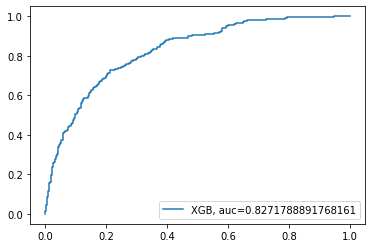



RandomForest
AUC de validación:  0.5520520983723886


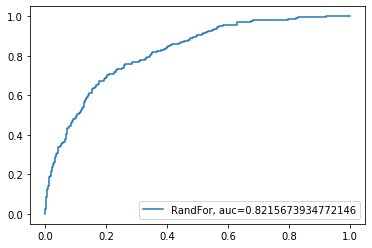



LogisticRegression
AUC de validación:  0.5847277236885944


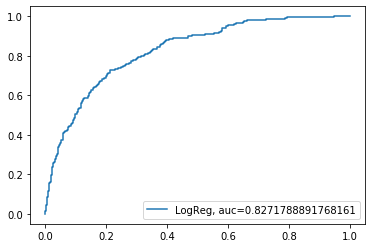



LGBMC
AUC de validación:  0.7657948642011871


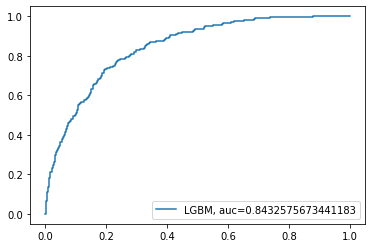



AdaBoost
AUC de validación:  0.5483810264193784


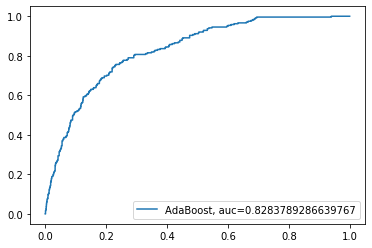

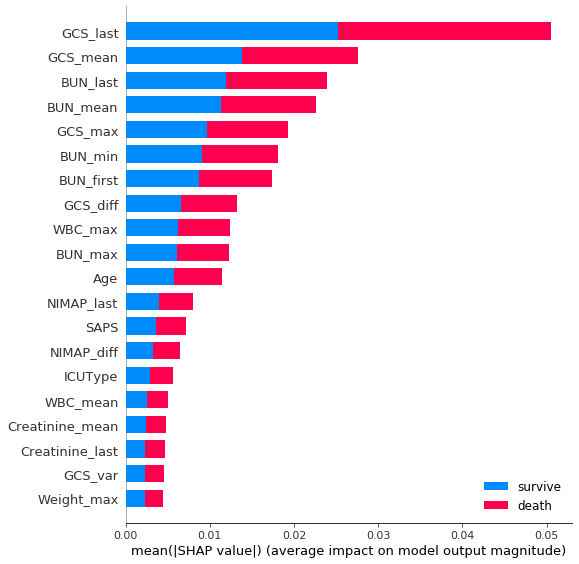

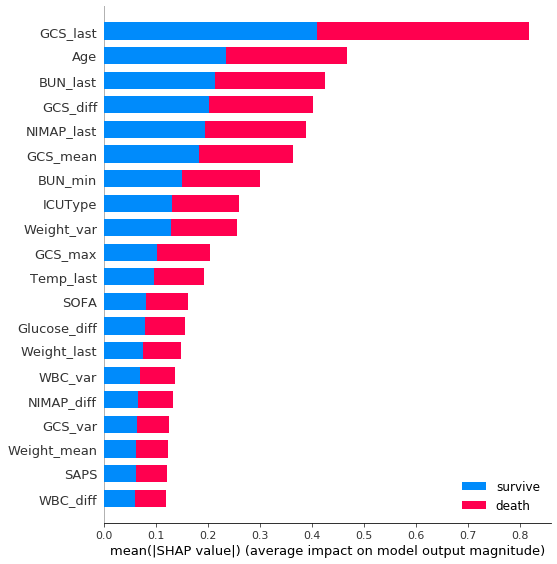

In [5]:
from sklearn import metrics

"""
Para cada variable graficamos su curva roc y el área bajo su curva para validación
"""

auc_val,_,_ = compute_auc(moXGB, x_val,y_val)
#print(i/100)
print("\n\nXGBClassifier\nAUC de validación: ",auc_val)


y_pred_proba = moXGB.predict_proba(x_val)[::,1]
fpr1, tpr1, _ = metrics.roc_curve(y_val,  y_pred_proba)
auc1 = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr1,tpr1,label="XGB, auc="+str(auc1))
plt.legend(loc=4)
plt.show()


auc_val,_,_ = compute_auc(moRand, x_val,y_val)
#print(i/100)
print("\n\nRandomForest\nAUC de validación: ",auc_val)

y_pred_proba = moRand.predict_proba(x_val)[::,1]
fpr1, tpr1, _ = metrics.roc_curve(y_val,  y_pred_proba)
auc1 = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr1,tpr1,label="RandFor, auc="+str(auc1))
plt.legend(loc=4)
plt.show()



auc_val,_,_ = compute_auc(moLog, x_val,y_val)
#print(i/100)
print("\n\nLogisticRegression\nAUC de validación: ",auc_val)

y_pred_proba = moXGB.predict_proba(x_val)[::,1]
fpr1, tpr1, _ = metrics.roc_curve(y_val,  y_pred_proba)
auc1 = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr1,tpr1,label="LogReg, auc="+str(auc1))
plt.legend(loc=4)
plt.show()


auc_val,_,_ = compute_auc(molgb, x_val,y_val)
#print(i/100)
print("\n\nLGBMC\nAUC de validación: ",auc_val)

y_pred_proba = molgb.predict_proba(x_val)[::,1]
fpr1, tpr1, _ = metrics.roc_curve(y_val,  y_pred_proba)
auc1 = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr1,tpr1,label="LGBM, auc="+str(auc1))
plt.legend(loc=4)
plt.show()

auc_val,_,_ = compute_auc(moAda, x_val,y_val)
#print(i/100)
print("\n\nAdaBoost\nAUC de validación: ",auc_val)

y_pred_proba = moAda.predict_proba(x_val)[::,1]
fpr1, tpr1, _ = metrics.roc_curve(y_val,  y_pred_proba)
auc1 = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr1,tpr1,label="AdaBoost, auc="+str(auc1))
plt.legend(loc=4)
plt.show()

import shap

"""
Para los modelos basados en árboles podemos verificar la importancia de cada variable para cada clase
"""

explainer = shap.TreeExplainer(moRand)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, feature_names=feature_list_t, class_names=['survive','death'])


explainer = shap.TreeExplainer(molgb)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, feature_names=feature_list_t, class_names=['survive','death'])


### 3.- Evaluando en Test
Utilizaremos los datos con los que se evaluaban los jugadores y con el Score que usaron

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def accTest(m, regresa=False, val=.5, x=x_test, disc=True):
    """
    Función que calcula las métricas utilizadas para la competencia, los jugadores fueron rankeados por
    el score "Score1", es el que debe importar.
    """
    if(disc):
        y_pred = m.predict(x)
        pred = list()
        for i in range(len(y_pred)):
            if(y_pred[i]>=val):
                pred.append(1)
            else:
                pred.append(0)

        test=list(y_test)

        a = accuracy_score(pred,test)
        print('Accuracy is:', a*100)

        CM = confusion_matrix(test, pred)
        TN = CM[0][0]
        FN = CM[1][0]
        TP = CM[1][1]
        FP = CM[0][1]
        precision=TP/(TP+FP)
        exha= TP/(TP+FN)
        print("TruePositive: ", TP,
             "\nTrueNEgative: ",TN,
             "\nF1 Score: ", (precision*exha)/(precision+exha),
             "\n\t Scoring for the challenge: \n\n\tSe= ", exha,
             "\n\tP= ", precision,
             "\n\nScore1: ", min(exha, precision),"\n\n\n")
        if regresa:
            return y_pred, a, CM
    elif (disc==False):
        y_pred = m.predict(x)
        test=list(y_test)

        a = accuracy_score(pred,test)
        print('Accuracy is:', a*100)
        
        CM = confusion_matrix(test, pred)
        TN = CM[0][0]
        FN = CM[1][0]
        TP = CM[1][1]
        FP = CM[0][1]
        precision=TP/(TP+FP)
        exha= TP/(TP+FN)
        print("TruePositive: ", TP,
             "\nTrueNEgative: ",TN,
             "\nF1 Score: ", (precision*exha)/(precision+exha),
             "\n\t Scoring for the challenge: \n\n\tSe= ", exha,
             "\n\tP= ", precision,
             "\n\nScore1: ", min(exha, precision),"\n\n\n")
        if regresa:
            return y_pred, a, CM
        


modelos=[moXGB, moRand, moAda, molgb, moLog]

for i in modelos:
    print("Resultado Test de ", i,"\n")
    accTest(i, disc=True)

Resultado Test de  XGBClassifier(colsample_bytree=0.8, eval_metric='auc', gamma=10,
              learning_rate=0.15, max_depth=4, reg_alpha=0.5, reg_lambda=2,
              scale_pos_weight=6.239819004524887, seed=442, subsample=0.8) 

Accuracy is: 83.525
TruePositive:  284 
TrueNEgative:  3057 
F1 Score:  0.23145884270578648 
	 Scoring for the challenge: 

	Se=  0.48547008547008547 
	P=  0.4423676012461059 

Score1:  0.4423676012461059 



Resultado Test de  RandomForestClassifier(max_depth=8, n_estimators=130, random_state=442) 

Accuracy is: 85.7
TruePositive:  23 
TrueNEgative:  3405 
F1 Score:  0.0372168284789644 
	 Scoring for the challenge: 

	Se=  0.039316239316239315 
	P=  0.696969696969697 

Score1:  0.039316239316239315 



Resultado Test de  AdaBoostClassifier(learning_rate=0.1, n_estimators=100, random_state=442) 

Accuracy is: 85.95
TruePositive:  41 
TrueNEgative:  3397 
F1 Score:  0.06366459627329192 
	 Scoring for the challenge: 

	Se=  0.07008547008547009 
	P=  0.694

#### Como podemos ver, los dos mejores modelos son LGBM y XGB

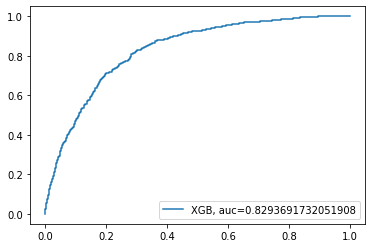

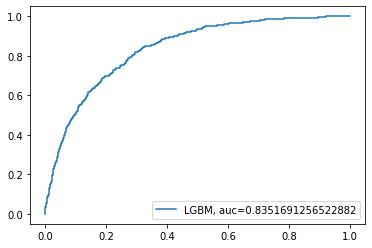

In [7]:
#Veamos sus curvas


y_pred_proba = moXGB.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="XGB, auc="+str(auc))
plt.legend(loc=4)
plt.show()

y_pred_proba = molgb.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="LGBM, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### 2.4.- Probamos con modelos naive

In [12]:
#Esto lo dejé al final debido a que la complejidad y el análisis que hice de los datos me hace saber que
#un modelo naive no iba a tener el mejor acercamiento

from sklearn.naive_bayes import BernoulliNB, GaussianNB

clf=BernoulliNB(alpha=0.005)
clf.fit(x_train, y_train)
accTest(clf)

Accuracy is: 40.675
TruePositive:  539 
TrueNEgative:  1088 
F1 Score:  0.1561866125760649 
	 Scoring for the challenge: 

	Se=  0.9213675213675213 
	P=  0.18806699232379623 

Score1:  0.18806699232379623 





In [13]:
clf=GaussianNB(priors=[.5, .5])
clf.fit(x_train, y_train)
accTest(clf)

Accuracy is: 84.95
TruePositive:  8 
TrueNEgative:  3390 
F1 Score:  0.012944983818770227 
	 Scoring for the challenge: 

	Se=  0.013675213675213675 
	P=  0.24242424242424243 

Score1:  0.013675213675213675 





## 3.- Explorando con PCA

Ahora, vamos a ver si utilizando menos dimensiones puede aumentar el Score1

In [8]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


In [14]:
from sklearn.decomposition import PCA

pca=PCA(n_components=16)
x_train_pca=pca.fit_transform(x_train)
x_val_pca=pca.transform(x_train)

In [15]:
x_test_pca=pca.transform(x_test)

In [16]:
clf=GaussianNB(priors=[.5, .5])
clf.fit(x_train_pca, y_train)
accTest(clf, x=x_test_pca)

Accuracy is: 65.375
TruePositive:  390 
TrueNEgative:  2225 
F1 Score:  0.18013856812933024 
	 Scoring for the challenge: 

	Se=  0.6666666666666666 
	P=  0.2468354430379747 

Score1:  0.2468354430379747 





#### Como podemos ver, el Score1 aumentó para un modelo tan simple, ahora veamos que pasa con mis modelos más complejos

In [18]:
x_test.shape

(4000, 166)

In [21]:
for i in range(2,166, 16):
    print("\n\n\n##########################################\nPCA= ", i)
    pca=PCA(n_components=i)
    x_train_pca=pca.fit_transform(x_train)
    x_val_pca=pca.transform(x_train)
    
    grid(x_tr=x_train_pca, y_tr=y_train)




##########################################
PCA=  2
best parameters are: RandomForestClassifier(max_depth=6, n_estimators=130, random_state=442)
RandomForestClassifier best AUC: 0.6932035724467974
best parameters are: XGBClassifier(colsample_bytree=0.8, eval_metric='auc', gamma=10,
              learning_rate=0.15, max_depth=2, reg_alpha=0.5, reg_lambda=2,
              scale_pos_weight=6.239819004524887, seed=442, subsample=0.4)
XGBClassifier best AUC: 0.6747913287083901
best parameters are: LogisticRegression(C=100.0, l1_ratio=0.5, penalty='elasticnet',
                   random_state=442, solver='saga')
LogisticRegression best AUC: 0.675185520004423
best parameters are: LGBMClassifier(bagging_fraction=0.5, boost_from_average='true', drop_rate=0.5,
               feature_fraction=0.8, is_unbalance='true', lambda_l2=0.9,
               max_bin=130, max_depth=2, metric='auc', min_data_in_bin=1,
               min_data_in_leaf=10, min_gain_to_split=10,
               min_sum_hessian_i

best parameters are: AdaBoostClassifier(learning_rate=0.9, n_estimators=100, random_state=442)
AdaBoostClassifier best AUC: 0.4971592398341164



##########################################
PCA=  114
best parameters are: RandomForestClassifier(max_depth=8, n_estimators=130, random_state=442)
RandomForestClassifier best AUC: 0.5546144540295862
best parameters are: XGBClassifier(colsample_bytree=0.8, eval_metric='auc', gamma=10,
              learning_rate=0.15, max_depth=4, reg_alpha=0.5, reg_lambda=2,
              scale_pos_weight=6.239819004524887, seed=442, subsample=0.8)
XGBClassifier best AUC: 0.5
best parameters are: LogisticRegression(C=100.0, l1_ratio=0.5, penalty='elasticnet',
                   random_state=442, solver='saga')
LogisticRegression best AUC: 0.5820234684601275
best parameters are: LGBMClassifier(bagging_fraction=0.5, boost_from_average='true', drop_rate=0.5,
               feature_fraction=0.8, is_unbalance='true', lambda_l2=0.09,
               max_bin=130, max_

##### El mejor modelo fue:
PCA=  34
best parameters are: RandomForestClassifier(max_depth=8, n_estimators=80, random_state=442)
RandomForestClassifier best AUC: 0.7482865616699966
best parameters are: XGBClassifier(colsample_bytree=0.8, eval_metric='auc', gamma=10,
              learning_rate=0.15, max_depth=4, reg_alpha=0.5, reg_lambda=2,
              scale_pos_weight=6.239819004524887, seed=442, subsample=0.8)
XGBClassifier best AUC: 0.5
best parameters are: LogisticRegression(C=1000.0, l1_ratio=0.5, penalty='elasticnet',
                   random_state=442, solver='saga')
LogisticRegression best AUC: 0.750618993099025
best parameters are: LGBMClassifier(bagging_fraction=0.5, boost_from_average='true', drop_rate=0.5,
               feature_fraction=0.8, is_unbalance='true', lambda_l2=0.09,
               max_bin=130, max_depth=10, metric='auc', min_data_in_bin=1,
               min_data_in_leaf=10, min_gain_to_split=10,
               min_sum_hessian_in_leaf=1e-10, num_iterations=200,
               objective='binary', seed=442)
Light best AUC: 0.5
best parameters are: AdaBoostClassifier(algorithm='SAMME', learning_rate=0.9, n_estimators=100,
                   random_state=442)
AdaBoostClassifier best AUC: 0.7192596085822609


In [34]:
#Entrenamos todos los modelos con el mejor auc

warnings.filterwarnings('ignore')

pca=PCA(n_components=29)
x_train_pca=pca.fit_transform(x_train)
x_val_pca=pca.transform(x_val)
x_test_pca=pca.transform(x_test)
    

moRand_pca=RandomForestClassifier(max_depth=8, n_estimators=80, random_state=442)
moRand_pca=moRand_pca.fit(x_train_pca,y_train)


moXGB_pca=XGBClassifier(colsample_bytree=0.8, eval_metric='auc', gamma=10,
              learning_rate=0.15, max_depth=4, reg_alpha=0.5, reg_lambda=2,
              scale_pos_weight=6.239819004524887, seed=442, subsample=0.8)
moXGB_pca=moXGB_pca.fit(x_train_pca, y_train)




moLog_pca=LogisticRegression(C=1000.0, l1_ratio=0.5, penalty='elasticnet',
                   random_state=442, solver='saga')

moLog_pca=moLog_pca.fit(x_train_pca, y_train)


molgb_pca=lgb.LGBMClassifier(bagging_fraction=0.5, boost_from_average='true', drop_rate=0.5,
               feature_fraction=0.8, is_unbalance='true', lambda_l2=0.09,
               max_bin=130, max_depth=10, metric='auc', min_data_in_bin=1,
               min_data_in_leaf=10, min_gain_to_split=10,
               min_sum_hessian_in_leaf=1e-10, num_iterations=200,
               objective='binary', seed=442)

molgb_pca=molgb_pca.fit(x_train_pca, y_train)


moAda_pca=AdaBoostClassifier(algorithm='SAMME', learning_rate=0.9, n_estimators=100,
                   random_state=442)

moAda_pca=moAda_pca.fit(x_train_pca, y_train)


modelos_pca=[moXGB_pca, moRand_pca, moAda_pca, molgb_pca, moLog_pca]

for i in modelos_pca:
    print("Resultado Test de ", i,"\n")
    accTest(i, disc=True, x=x_test_pca)

Resultado Test de  XGBClassifier(colsample_bytree=0.8, eval_metric='auc', gamma=10,
              learning_rate=0.15, max_depth=4, reg_alpha=0.5, reg_lambda=2,
              scale_pos_weight=6.239819004524887, seed=442, subsample=0.8) 

Accuracy is: 79.07499999999999
TruePositive:  343 
TrueNEgative:  2820 
F1 Score:  0.2252133946158897 
	 Scoring for the challenge: 

	Se=  0.5863247863247864 
	P=  0.3656716417910448 

Score1:  0.3656716417910448 



Resultado Test de  RandomForestClassifier(max_depth=8, n_estimators=80, random_state=442) 

Accuracy is: 85.425
TruePositive:  9 
TrueNEgative:  3408 
F1 Score:  0.014975041597337773 
	 Scoring for the challenge: 

	Se=  0.015384615384615385 
	P=  0.5625 

Score1:  0.015384615384615385 



Resultado Test de  AdaBoostClassifier(algorithm='SAMME', learning_rate=0.9, n_estimators=100,
                   random_state=442) 

Accuracy is: 85.6
TruePositive:  108 
TrueNEgative:  3316 
F1 Score:  0.13636363636363635 
	 Scoring for the challenge: 


como podemos ver, el mejor es:
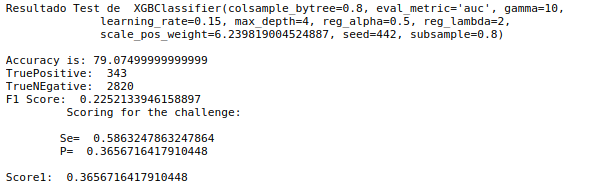
sin embargo, está .1 debajo del mejor anterior

## 4.- Explorando con redes neuronales

Ahora trataré de lograr un resultado similar al obtenido, utilizando redes neuronales y mi casi nulo conocimiento xd

In [ ]:

def accTest(m, regresa=False, val=.5, x=x_test, disc=False):
    """
    Función que calcula las métricas utilizadas para la competencia, los jugadores fueron rankeados por
    el score "Score1", es el que debe importar.
    """
    if(disc==False):
        y_pred = m.predict(x)
        predi = list()
        for i in range(len(y_pred)):
            if(y_pred[i]>=val):
                predi.append(1)
            else:
                predi.append(0)

        test=list(y_test)

        a = accuracy_score(predi,test)
        print('Accuracy is:', a*100)

        CM = confusion_matrix(test, predi)
        TN = CM[0][0]
        FN = CM[1][0]
        TP = CM[1][1]
        FP = CM[0][1]
        precision=TP/(TP+FP)
        exha= TP/(TP+FN)
        print("TruePositive: ", TP,
             "\nTrueNEgative: ",TN,
             "\nF1 Score: ", (precision*exha)/(precision+exha),
             "\n\t Scoring for the challenge: \n\n\tSe= ", exha,
             "\n\tP= ", precision,
             "\n\nScore1: ", min(exha, precision),"\n\n\n")
        if regresa:
            return y_pred, a, CM
    elif (disc!=False):
        y_pred = m.predict(x)
        test=list(y_test)
        predi = list()

        a = accuracy_score(predi,test)
        print('Accuracy is:', a*100)
        
        CM = confusion_matrix(test, predi)
        TN = CM[0][0]
        FN = CM[1][0]
        TP = CM[1][1]
        FP = CM[0][1]
        precision=TP/(TP+FP)
        exha= TP/(TP+FN)
        print("TruePositive: ", TP,
             "\nTrueNEgative: ",TN,
             "\nF1 Score: ", (precision*exha)/(precision+exha),
             "\n\t Scoring for the challenge: \n\n\tSe= ", exha,
             "\n\tP= ", precision,
             "\n\nScore1: ", min(exha, precision),"\n\n\n")
        if regresa:
            return y_pred, a, CM

In [65]:
#solo mostraré el mejor modelo logrado
model3= Sequential()
model3.add(Dense(64, input_dim=166, activation='sigmoid'))
model3.add(Dropout(.2))
model3.add(Dense(1, activation='sigmoid'))
opt=keras.optimizers.Adam()
model3.compile(loss='binary_crossentropy', optimizer=opt,
              metrics=['accuracy'])
history3 = model3.fit(x_train, y_train, epochs=10,validation_data = (x_val,y_val),
                      class_weight={0:.35, 1:.65}, batch_size=32)

accTest(model3, disc=False)


Train on 6400 samples, validate on 1600 samples
Epoch 1/10
6400/6400 [==============================] - 1s 218us/step - loss: 0.1782 - accuracy: 0.8561 - val_loss: 0.3510 - val_accuracy: 0.8487
Epoch 2/10
6400/6400 [==============================] - 1s 139us/step - loss: 0.1582 - accuracy: 0.8673 - val_loss: 0.3466 - val_accuracy: 0.8456
Epoch 3/10
6400/6400 [==============================] - 1s 131us/step - loss: 0.1529 - accuracy: 0.8662 - val_loss: 0.3423 - val_accuracy: 0.8444
Epoch 4/10
6400/6400 [==============================] - 1s 130us/step - loss: 0.1530 - accuracy: 0.8628 - val_loss: 0.3302 - val_accuracy: 0.8581
Epoch 5/10
6400/6400 [==============================] - 1s 135us/step - loss: 0.1517 - accuracy: 0.8648 - val_loss: 0.3306 - val_accuracy: 0.8500
Epoch 6/10
6400/6400 [==============================] - 1s 135us/step - loss: 0.1502 - accuracy: 0.8677 - val_loss: 0.3315 - val_accuracy: 0.8562
Epoch 7/10
6400/6400 [==============================] - 1s 134us/step - loss

## Como podemos ver, obtuvimos un accuracy mejor que con los modelos tradicionales.
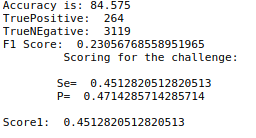

## 5.- Utilizando over sampling

In [66]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
#ROS=RandomOverSampler(random_state=0)
X_resampled, y_resampled= SMOTE().fit_resample(x_all, y_all)

In [67]:
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 6878), (1, 6878)]


In [68]:
X_resampled.shape

(13756, 166)

In [69]:
x_all.shape

(8000, 166)

In [70]:
x_train_ovs, x_val_ovs, y_train_ovs, y_val_ovs = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=422) #división de los datos
sample_weights = class_weight.compute_sample_weight('balanced', y_train_ovs)
ratio = float(np.sum(y_train_ovs == 0)) / np.sum(y_train_ovs==1)
cv = StratifiedKFold(n_splits=3)

### 5.1.- Grid search con SMOTE

In [72]:
grid(x_tr=x_train_ovs, y_tr=y_train_ovs)

best parameters are: RandomForestClassifier(max_depth=8, n_estimators=130, random_state=442)
RandomForestClassifier best AUC: 0.9492413421939855
best parameters are: XGBClassifier(colsample_bytree=0.8, eval_metric='auc', gamma=10,
              learning_rate=0.25, max_depth=4, reg_alpha=0.5, reg_lambda=2,
              scale_pos_weight=0.981274756931941, seed=442, subsample=0.8)
XGBClassifier best AUC: 0.9741773023110074
best parameters are: LogisticRegression(l1_ratio=0.5, penalty='elasticnet', random_state=442,
                   solver='saga')
LogisticRegression best AUC: 0.8630227904405563
best parameters are: LGBMClassifier(bagging_fraction=0.5, boost_from_average='true', drop_rate=0.5,
               feature_fraction=0.6, is_unbalance='true', lambda_l2=0.09,
               max_bin=130, max_depth=10, metric='auc', min_data_in_bin=1,
               min_data_in_leaf=10, min_gain_to_split=10,
               min_sum_hessian_in_leaf=1e-10, num_iterations=200,
               objective='

In [105]:

mo1=RandomForestClassifier(max_depth=8, n_estimators=130, random_state=442)
mo1.fit(x_train_ovs, y_train_ovs)
print(mo1)
accTest(mo1)


mo2=XGBClassifier(colsample_bytree=0.8, eval_metric='auc', gamma=10,
              learning_rate=0.25, max_depth=4, reg_alpha=0.5, reg_lambda=2,
              scale_pos_weight=0.981274756931941, seed=442, subsample=0.5)
mo2.fit(x_train_ovs, y_train_ovs)
print(mo2)
accTest(mo2)



mo3=LogisticRegression(l1_ratio=0.5, penalty='elasticnet', random_state=442,
                   solver='saga')
print(mo3)
mo3.fit(x_train_ovs, y_train_ovs)
accTest(mo3)

mo4=lgb.LGBMClassifier(bagging_fraction=0.5, boost_from_average='true', drop_rate=0.5,
               feature_fraction=0.6, is_unbalance='true', lambda_l2=0.09,
               max_bin=130, max_depth=10, metric='auc', min_data_in_bin=1,
               min_data_in_leaf=10, min_gain_to_split=10,
               min_sum_hessian_in_leaf=1e-10, num_iterations=200,
               objective='binary', seed=442)
mo4.fit(x_train_ovs, y_train_ovs)
print(mo4)
accTest(mo4)

mo5= AdaBoostClassifier(learning_rate=0.9, n_estimators=100, random_state=442)
mo5.fit(x_train_ovs, y_train_ovs)
print(mo5)
accTest(mo5)


RandomForestClassifier(max_depth=8, n_estimators=130, random_state=442)
Accuracy is: 69.22500000000001
TruePositive:  443 
TrueNEgative:  2326 
F1 Score:  0.2092583845063769 
	 Scoring for the challenge: 

	Se=  0.7572649572649572 
	P=  0.2891644908616188 

Score1:  0.2891644908616188 



XGBClassifier(colsample_bytree=0.8, eval_metric='auc', gamma=10,
              learning_rate=0.25, max_depth=4, reg_alpha=0.5, reg_lambda=2,
              scale_pos_weight=0.981274756931941, seed=442, subsample=0.5)
Accuracy is: 26.125
TruePositive:  559 
TrueNEgative:  486 
F1 Score:  0.1372452737539897 
	 Scoring for the challenge: 

	Se=  0.9555555555555556 
	P=  0.1602637614678899 

Score1:  0.1602637614678899 



LogisticRegression(l1_ratio=0.5, penalty='elasticnet', random_state=442,
                   solver='saga')
Accuracy is: 76.14999999999999
TruePositive:  441 
TrueNEgative:  2605 
F1 Score:  0.24019607843137253 
	 Scoring for the challenge: 

	Se=  0.7538461538461538 
	P=  0.3525179856115

#### Como podemos observar, se ha sobreajustado cada modelo, realizando una busqueda manual de pesos encontré el mejor para los modelos y se presentan a continuación con el mejor SCORE obtenido

In [106]:
mo1=RandomForestClassifier(max_depth=8, n_estimators=130, random_state=442, class_weight={0:.76, 1:.24})
mo1.fit(x_train_ovs, y_train_ovs)
print(mo1)
accTest(mo1)


mo2=XGBClassifier(colsample_bytree=0.8, eval_metric='auc', gamma=10,
              learning_rate=0.25, max_depth=4, reg_alpha=0.5, reg_lambda=2,
              scale_pos_weight=0.981274756931941, seed=442,class_weight={0:.76, 1:.24}, subsample=0.5)
mo2.fit(x_train_ovs, y_train_ovs)
print(mo2)
accTest(mo2)



mo3=LogisticRegression(l1_ratio=0.5, penalty='elasticnet',class_weight={0:.76, 1:.24}, random_state=442,
                   solver='saga')
print(mo3)
mo3.fit(x_train_ovs, y_train_ovs)
accTest(mo3)

mo4=lgb.LGBMClassifier(bagging_fraction=0.5, boost_from_average='true', drop_rate=0.5,
               feature_fraction=0.6, is_unbalance='true', lambda_l2=0.09,
               max_bin=130, max_depth=10, metric='auc', min_data_in_bin=1,
               min_data_in_leaf=10, min_gain_to_split=10,
               min_sum_hessian_in_leaf=1e-10, class_weight={0:.76, 1:.24},num_iterations=200,
               objective='binary', seed=442)
mo4.fit(x_train_ovs, y_train_ovs)
print(mo4)
accTest(mo4)

mo5= AdaBoostClassifier(learning_rate=0.9, n_estimators=100, random_state=442)
mo5.fit(x_train_ovs, y_train_ovs)
print(mo5)
accTest(mo5)



RandomForestClassifier(class_weight={0: 0.76, 1: 0.24}, max_depth=8,
                       n_estimators=130, random_state=442)
Accuracy is: 80.75
TruePositive:  286 
TrueNEgative:  2944 
F1 Score:  0.21311475409836067 
	 Scoring for the challenge: 

	Se=  0.4888888888888889 
	P=  0.37780713342140027 

Score1:  0.37780713342140027 



XGBClassifier(class_weight={0: 0.76, 1: 0.24}, colsample_bytree=0.8,
              eval_metric='auc', gamma=10, learning_rate=0.25, max_depth=4,
              reg_alpha=0.5, reg_lambda=2, scale_pos_weight=0.981274756931941,
              seed=442, subsample=0.5)
Accuracy is: 26.125
TruePositive:  559 
TrueNEgative:  486 
F1 Score:  0.1372452737539897 
	 Scoring for the challenge: 

	Se=  0.9555555555555556 
	P=  0.1602637614678899 

Score1:  0.1602637614678899 



LogisticRegression(class_weight={0: 0.76, 1: 0.24}, l1_ratio=0.5,
                   penalty='elasticnet', random_state=442, solver='saga')
Accuracy is: 85.275
TruePositive:  270 
TrueNEgative: 

El modelo ganador es:
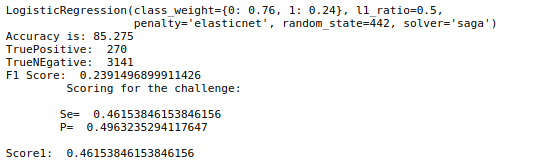
Que nos ubicaría en el 8° lugar del challenge

### 5.2 Probando SMOTE con NN

In [125]:
model3= Sequential()
model3.add(Dense(128, input_dim=166, activation='sigmoid'))
model3.add(Dropout(.2))
model3.add(Dense(1, activation='sigmoid'))
opt=keras.optimizers.Adam()
model3.compile(loss='binary_crossentropy', optimizer=opt,
              metrics=['accuracy'])
history3 = model3.fit(x_train_ovs, y_train_ovs, epochs=200,validation_data = (x_val_ovs,y_val_ovs),
                      class_weight={0:.76, 1:.24}, batch_size=32)

accTest(model3, disc=False)


Train on 11004 samples, validate on 2752 samples
Epoch 1/200
11004/11004 [==============================] - 2s 213us/step - loss: 0.2263 - accuracy: 0.6457 - val_loss: 0.5581 - val_accuracy: 0.6995
Epoch 2/200
11004/11004 [==============================] - 2s 153us/step - loss: 0.1937 - accuracy: 0.7064 - val_loss: 0.5896 - val_accuracy: 0.6857
Epoch 3/200
11004/11004 [==============================] - 2s 152us/step - loss: 0.1893 - accuracy: 0.7145 - val_loss: 0.5506 - val_accuracy: 0.7071
Epoch 4/200
11004/11004 [==============================] - 2s 154us/step - loss: 0.1874 - accuracy: 0.7196 - val_loss: 0.5379 - val_accuracy: 0.7118
Epoch 5/200
11004/11004 [==============================] - 2s 153us/step - loss: 0.1845 - accuracy: 0.7241 - val_loss: 0.5538 - val_accuracy: 0.7042
Epoch 6/200
11004/11004 [==============================] - 2s 156us/step - loss: 0.1808 - accuracy: 0.7340 - val_loss: 0.5551 - val_accuracy: 0.7137
Epoch 7/200
11004/11004 [==============================] 

11004/11004 [==============================] - 2s 149us/step - loss: 0.0586 - accuracy: 0.9338 - val_loss: 0.2059 - val_accuracy: 0.9237
Epoch 56/200
11004/11004 [==============================] - 2s 150us/step - loss: 0.0568 - accuracy: 0.9357 - val_loss: 0.2096 - val_accuracy: 0.9193
Epoch 57/200
11004/11004 [==============================] - 2s 151us/step - loss: 0.0580 - accuracy: 0.9375 - val_loss: 0.2162 - val_accuracy: 0.9117
Epoch 58/200
11004/11004 [==============================] - 2s 149us/step - loss: 0.0587 - accuracy: 0.9329 - val_loss: 0.2006 - val_accuracy: 0.9241
Epoch 59/200
11004/11004 [==============================] - 2s 148us/step - loss: 0.0557 - accuracy: 0.9386 - val_loss: 0.1960 - val_accuracy: 0.9270
Epoch 60/200
11004/11004 [==============================] - 2s 147us/step - loss: 0.0538 - accuracy: 0.9419 - val_loss: 0.1983 - val_accuracy: 0.9255
Epoch 61/200
11004/11004 [==============================] - 2s 151us/step - loss: 0.0544 - accuracy: 0.9400 - val

11004/11004 [==============================] - 2s 148us/step - loss: 0.0356 - accuracy: 0.9620 - val_loss: 0.1606 - val_accuracy: 0.9422
Epoch 110/200
11004/11004 [==============================] - 2s 147us/step - loss: 0.0346 - accuracy: 0.9606 - val_loss: 0.1559 - val_accuracy: 0.9448
Epoch 111/200
11004/11004 [==============================] - 2s 149us/step - loss: 0.0322 - accuracy: 0.9656 - val_loss: 0.1600 - val_accuracy: 0.9437
Epoch 112/200
11004/11004 [==============================] - 2s 149us/step - loss: 0.0344 - accuracy: 0.9635 - val_loss: 0.1610 - val_accuracy: 0.9408
Epoch 113/200
11004/11004 [==============================] - 2s 148us/step - loss: 0.0320 - accuracy: 0.9654 - val_loss: 0.1603 - val_accuracy: 0.9426
Epoch 114/200
11004/11004 [==============================] - 2s 150us/step - loss: 0.0331 - accuracy: 0.9640 - val_loss: 0.1566 - val_accuracy: 0.9430
Epoch 115/200
11004/11004 [==============================] - 2s 149us/step - loss: 0.0350 - accuracy: 0.9639

11004/11004 [==============================] - 2s 149us/step - loss: 0.0259 - accuracy: 0.9733 - val_loss: 0.1458 - val_accuracy: 0.9520
Epoch 164/200
11004/11004 [==============================] - 2s 149us/step - loss: 0.0257 - accuracy: 0.9731 - val_loss: 0.1466 - val_accuracy: 0.9480
Epoch 165/200
11004/11004 [==============================] - 2s 151us/step - loss: 0.0245 - accuracy: 0.9746 - val_loss: 0.1508 - val_accuracy: 0.9459
Epoch 166/200
11004/11004 [==============================] - 2s 150us/step - loss: 0.0258 - accuracy: 0.9736 - val_loss: 0.1491 - val_accuracy: 0.9469
Epoch 167/200
11004/11004 [==============================] - 2s 152us/step - loss: 0.0246 - accuracy: 0.9742 - val_loss: 0.1488 - val_accuracy: 0.9480
Epoch 168/200
11004/11004 [==============================] - 2s 149us/step - loss: 0.0248 - accuracy: 0.9731 - val_loss: 0.1539 - val_accuracy: 0.9444
Epoch 169/200
11004/11004 [==============================] - 2s 149us/step - loss: 0.0236 - accuracy: 0.9756

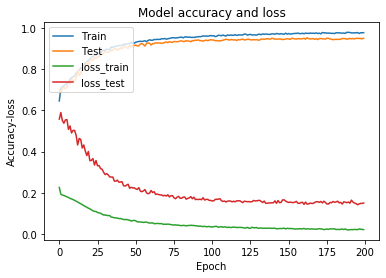

In [126]:
import matplotlib.pyplot as plt
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model accuracy and loss')
plt.ylabel('Accuracy-loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test', 'loss_train', 'loss_test'], loc='upper left')
plt.show()

In [213]:

model3= Sequential()
model3.add(Dense(2, input_dim=166, activation='sigmoid'))
model3.add(Dense(2, activation='softmax'))
#model3.add(Dropout(.2))
model3.add(Dense(1, activation='sigmoid'))
opt=keras.optimizers.Adam(.001)
model3.compile(loss='binary_crossentropy', optimizer=opt,
              metrics=['accuracy', keras.metrics.SpecificityAtSensitivity(.5)])
history3 = model3.fit(x_train_ovs, y_train_ovs, epochs=25,validation_data = (x_val_ovs,y_val_ovs),
                      class_weight={0:.78, 1:.22})

accTest(model3, disc=False)


Train on 11004 samples, validate on 2752 samples
Epoch 1/25
11004/11004 [==============================] - 5s 452us/step - loss: 0.2709 - accuracy: 0.4953 - specificity_at_sensitivity_23: 0.5433 - val_loss: 0.7934 - val_accuracy: 0.5189 - val_specificity_at_sensitivity_23: 0.8242
Epoch 2/25
11004/11004 [==============================] - 3s 242us/step - loss: 0.2542 - accuracy: 0.4953 - specificity_at_sensitivity_23: 0.8859 - val_loss: 0.7647 - val_accuracy: 0.5189 - val_specificity_at_sensitivity_23: 0.8873
Epoch 3/25
11004/11004 [==============================] - 3s 263us/step - loss: 0.2330 - accuracy: 0.4953 - specificity_at_sensitivity_23: 0.8822 - val_loss: 0.6927 - val_accuracy: 0.5189 - val_specificity_at_sensitivity_23: 0.9013
Epoch 4/25
11004/11004 [==============================] - 3s 270us/step - loss: 0.2141 - accuracy: 0.4953 - specificity_at_sensitivity_23: 0.8974 - val_loss: 0.6445 - val_accuracy: 0.5189 - val_specificity_at_sensitivity_23: 0.9020
Epoch 5/25
11004/11004 

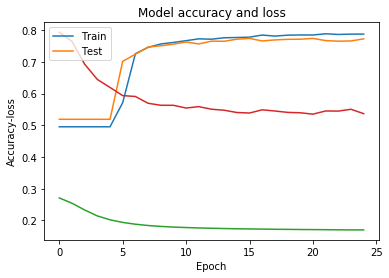

In [214]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model accuracy and loss')
plt.ylabel('Accuracy-loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')#, 'loss_train', 'loss_val'], loc='upper left')
plt.show()

### Por último
Para u ntrabajo futuro, con más poder de cómputo podría intentar con distintas arquitecturas y una búsqueda de parámetros más exhaustiva y considero que llegar a un buen SCORE (lograr subir .1) no suena tan imposible. Para mayores detalles visitar el artículo en:


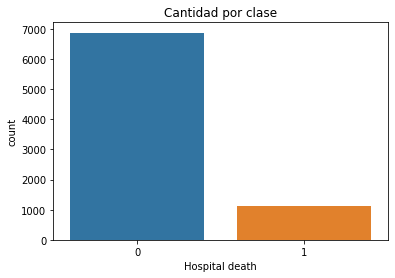

In [216]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.title('Cantidad por clase')
sns.countplot(x="hospital_death", data=pd_data)
plt.xlabel('Hospital death')
plt.show()

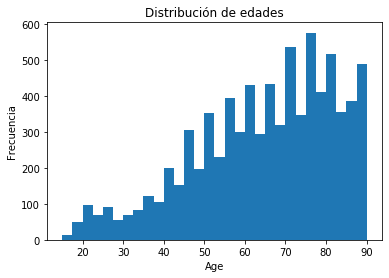

In [218]:
plt.figure(figsize=(6,4))
plt.title("Distribución de edades")
plt.hist(pd_data['Age'], bins = 30)
plt.ylabel('Frecuencia')
plt.xlabel('Age')
plt.show()

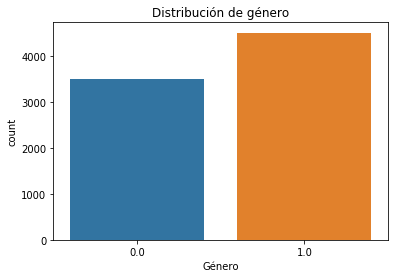

In [220]:
plt.figure(figsize=(6,4))
sns.countplot(x="Gender", data=pd_data) #0: femenino, 1: masculino
plt.title('Distribución de género')
plt.xlabel('Género')
plt.show()

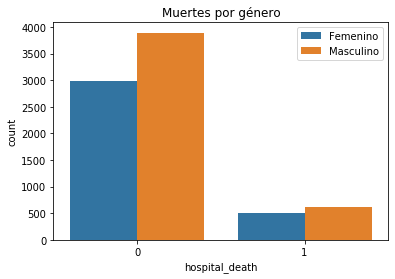

In [224]:
sns.countplot(data=pd_data,hue='Gender',x='hospital_death')
plt.title('Muertes por género')
plt.legend(['Femenino', 'Masculino'])
plt.show()

In [228]:
pd_data.describe()

,Age,Gender,Height,ICUType,SAPS,SOFA,STAY,SURV
count,8000.000000,7992.000000,4176.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,64.429750,0.562938,169.724569,2.783750,14.243750,6.364625,13.584875,130.426875
std,17.352628,0.496054,17.378792,1.013096,6.044825,4.237236,12.715975,364.766144
min,15.000000,0.000000,1.800000,1.000000,-1.000000,-1.000000,-1.000000,-23.000000
25%,53.000000,0.000000,162.600000,2.000000,11.000000,3.000000,6.000000,-1.000000
50%,67.000000,1.000000,170.200000,3.000000,15.000000,6.000000,10.000000,-1.000000
75%,78.000000,1.000000,177.800000,4.000000,18.000000,9.000000,17.000000,17.000000
max,90.000000,1.000000,462.300000,4.000000,34.000000,22.000000,171.000000,2620.000000
